<a href="https://colab.research.google.com/github/chrysshawk/ExData_Plotting1/blob/master/ARIMA_code_along.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps in ARIMA
1. Visualize the data
2. Make it non stationary
3. Plot the correlation & Autocorrelation (AR) charts
4. Construct the ARIMA model
5. Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from google.colab import drive
from datetime import date

# Setting defaults
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Mounting Google
#path = 'drive/MyDrive/Colab Notebooks/Udemy - Python for Finance/04-Visualization-Matplotlib-Pandas/04-02-Pandas Visualization/'
drive.mount('/content/drive', force_remount=True)
path = 'drive/MyDrive/Colab Notebooks/Udemy - Python for Finance/' + '08-Time-Series-Analysis/'

Mounted at /content/drive


In [4]:
ttf = pd.read_csv(path+'ttf_ass_dah.csv', index_col='Date', parse_dates=True)

In [5]:
ttf.head()

,Bid,Offer,Mid
Date,,,
2014-01-02,26.350,26.400,26.375
2014-01-03,26.250,26.300,26.275
2014-01-06,26.575,26.625,26.600
2014-01-07,26.475,26.525,26.500
2014-01-08,26.825,26.875,26.850


In [6]:
ttfm = ttf.resample(rule='MS').mean()

In [7]:
ttfm.head()

,Bid,Offer,Mid
Date,,,
2014-01-01,26.231818,26.272727,26.252455
2014-02-01,23.767500,23.812500,23.790100
2014-03-01,22.716667,22.776190,22.746524
2014-04-01,20.232500,20.292500,20.262600
2014-05-01,18.993750,19.062500,19.028300


In [8]:
ttfm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Bid,84.0,16.840353,5.239633,4.515789,13.198750,17.226786,20.857308,27.8550
Offer,84.0,16.874740,5.241023,4.576316,13.225045,17.250595,20.885069,27.8750
Mid,84.0,16.857771,5.240296,4.546263,13.212096,17.238929,20.871476,27.8651


## 1. Visualize

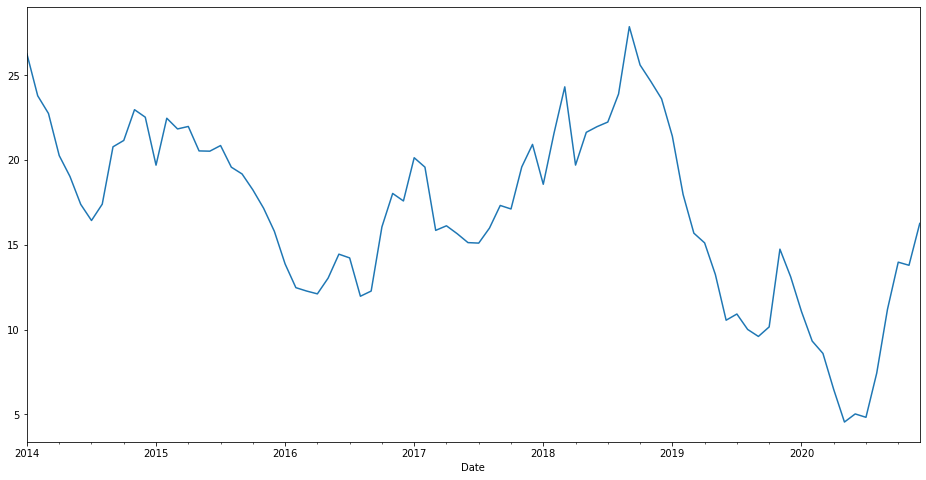

In [9]:
ttfm['Mid'].plot(figsize=(16,8));

In [10]:
time_series = ttfm['Mid']

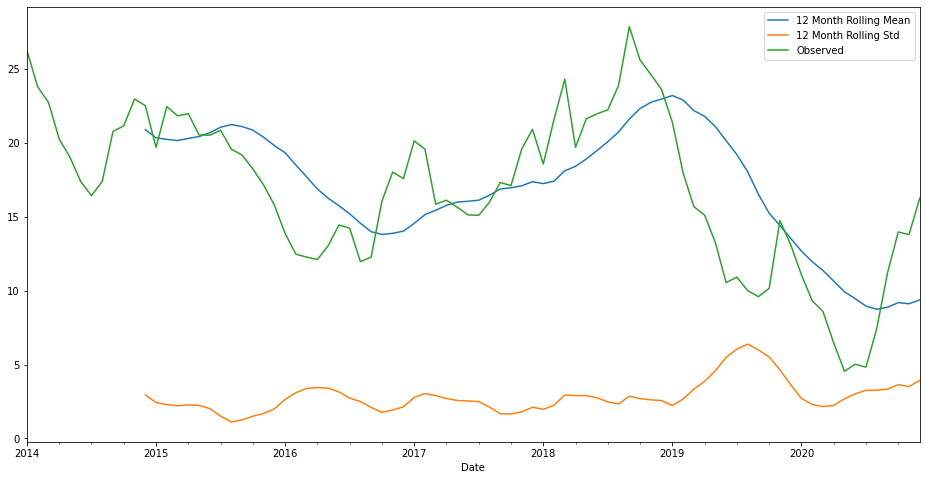

In [11]:
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean', figsize=(16,8))
time_series.rolling(12).std().plot(label='12 Month Rolling Std', figsize=(16,8))
time_series.plot(label='Observed')
plt.legend();

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
decomp = seasonal_decompose(time_series, model='additive')

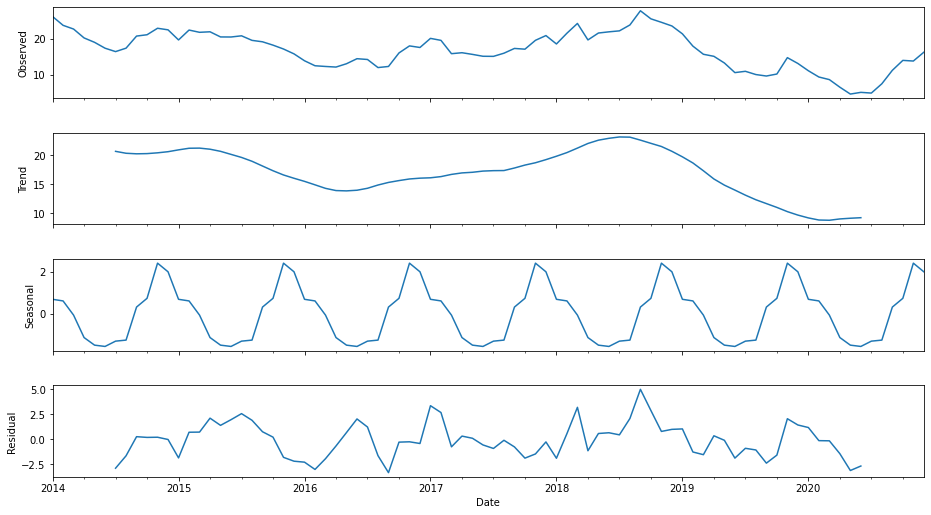

In [14]:
#plt.rcParams['figure.figsize'] = (14, 9)
fig = decomp.plot()
fig.set_size_inches(14,8)

## 2. Test for Stationarity

- the null hypothesis indicates it is a non-stationary time series
- the alternative hypothesis is the series has no unit root and is stationary
- we will decide on this based on the p-value returned; 
  - a small p-value, typically less than 0.05, indicates strong evidence against the null hypothesis
  - a larger p-value indicates weak evidence against the null hypothesis, so you fail to reject it (does not mean you accept it though!)

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
result = adfuller(ttfm['Mid'])
result

(-2.672666772950518,
 0.0788887094039617,
 3,
 80,
 {'1%': -3.5148692050781247, '10%': -2.58643890625, '5%': -2.8984085156250003},
 289.9691604360674)

In [17]:
def adf_check(time_series):

  result = adfuller(time_series)
  print('===AUGMENTED DICKY-FULLER TEST===')
  labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations Used']

  for value,label in zip(result,labels):
    print(label + ' : ' + str(value))

  if result[1] <= 0.05:
    print('Strong evidence against null hypothesis.')
    print('Reject null hypothesis.')
    print('Series has no unit root and is stationary.')
  else:
    print('Weak evidence against null hypothesis.')
    print('Failed to reject null hypothesis.')
    print('Data has a unit root, it is non-stationary.')

In [18]:
adf_check(ttfm['Mid'])

===AUGMENTED DICKY-FULLER TEST===
ADF Test Statistic : -2.672666772950518
p-value : 0.0788887094039617
# of lags : 3
Num of Observations Used : 80
Weak evidence against null hypothesis.
Failed to reject null hypothesis.
Data has a unit root, it is non-stationary.


In [19]:
ttfm['First Difference'] = ttfm['Mid'] - ttf['Mid'].shift(1)

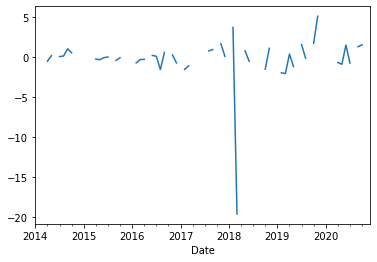

In [20]:
ttfm['First Difference'].plot();

From the above, we can see the series is stationary; i.e. it is on average flat without a trend.

In [21]:
adf_check(ttfm['First Difference'].dropna())

===AUGMENTED DICKY-FULLER TEST===
ADF Test Statistic : -8.3894929713359
p-value : 2.3879554469477315e-13
# of lags : 0
Num of Observations Used : 51
Strong evidence against null hypothesis.
Reject null hypothesis.
Series has no unit root and is stationary.


In [22]:
# We don't need to do the below; it's just an example in case we would need to
ttfm['Second Difference'] = ttfm['First Difference'] - ttfm['First Difference'].shift(1)

In [23]:
adf_check(ttfm['Second Difference'].dropna())

===AUGMENTED DICKY-FULLER TEST===
ADF Test Statistic : -4.854371979452026
p-value : 4.275383569339445e-05
# of lags : 0
Num of Observations Used : 28
Strong evidence against null hypothesis.
Reject null hypothesis.
Series has no unit root and is stationary.


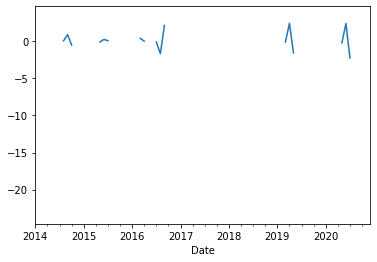

In [24]:
ttfm['Second Difference'].plot();

Again, from the avbove, there's not much of a trend here.

For the hell of it, we can also do a seasonal difference.

In [25]:
ttfm['Seasonal Difference'] = ttfm['Mid'] - ttfm['Mid'].shift(12) #shifting by an entire year to negate the seasons

In [26]:
adf_check(ttfm['Seasonal Difference'].dropna())

===AUGMENTED DICKY-FULLER TEST===
ADF Test Statistic : -1.6014237434372571
p-value : 0.48287823706784744
# of lags : 12
Num of Observations Used : 59
Weak evidence against null hypothesis.
Failed to reject null hypothesis.
Data has a unit root, it is non-stationary.


The above is the case, since there is not strong seasonal profile in the series.

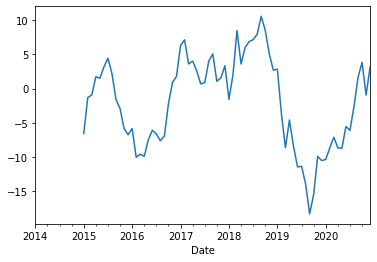

In [27]:
ttfm['Seasonal Difference'].plot();

In [28]:
# Do seasonal first difference (second pass on season, like we did further up)
ttfm['Seasonal First Difference'] = ttfm['Seasonal Difference'] - ttfm['Seasonal Difference'].shift(12)

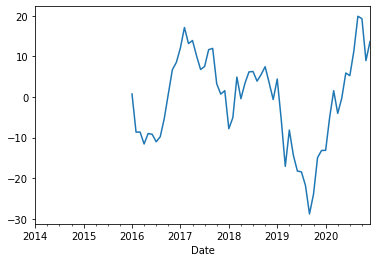

In [29]:
ttfm['Seasonal First Difference'].plot();

In [30]:
adf_check(ttfm['Seasonal First Difference'].dropna())

===AUGMENTED DICKY-FULLER TEST===
ADF Test Statistic : -3.2181539363954204
p-value : 0.018957614594549574
# of lags : 7
Num of Observations Used : 52
Strong evidence against null hypothesis.
Reject null hypothesis.
Series has no unit root and is stationary.


So there we go. Examples on how to make stationary series from both the monthly (shift 1) differences and seasonal (shift 12) differences. The monthly only required one pass though.

## Plot correlations and autocorrelations

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

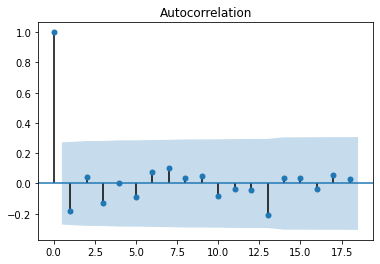

In [32]:
fig_first = plot_acf(ttfm['First Difference'].dropna())

The above is the "sudden drop" auto correlation; indicating it is stationary.

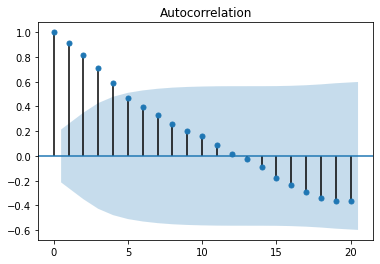

In [33]:
fig_mid = plot_acf(ttfm['Mid'].dropna())

The above is the "gradual descent" autocorrelation, indicating non-stationarity.

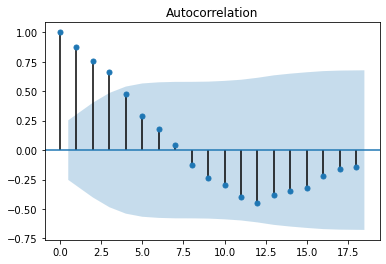

In [34]:
fig_seasonal_first = plot_acf(ttfm['Seasonal First Difference'].dropna())

### Partial autocorrelation; PACF

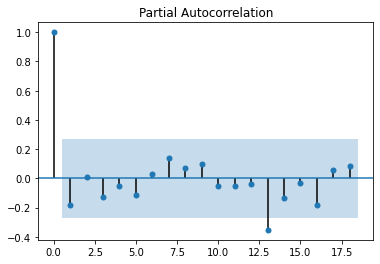

In [35]:
pacf_firstdiff = plot_pacf(ttfm['First Difference'].dropna())

###Interpreting the above
- an aggressive drop-off after a k-number of lag, indicates one should use some auto-regressive, k-number, model
- a gradual decline indicates the use of a moving average model

Now, let's choose the "final" plots we're going to use for the ARIMA model.
Use the first difference, since that gave the best result.

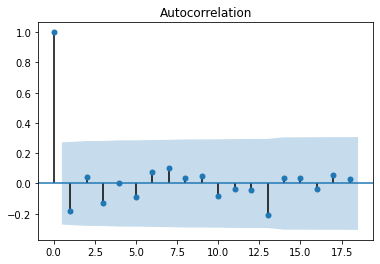

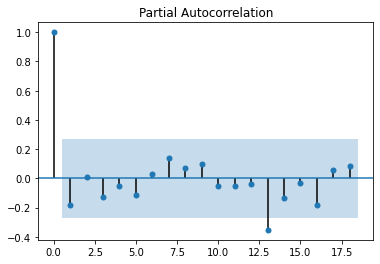

In [36]:
acf_plot = plot_acf(ttfm['First Difference'].dropna())
pacf_plot = plot_pacf(ttfm['First Difference'].dropna())

##4. ARIMA MODEL

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [93]:
# for standard ARIMA, just call ARIMA
# for seasonal ARIMA, see below

In [79]:
# NOTE: read up on the input params required in the below model; p,d,q specifically
model = sm.tsa.statespace.SARIMAX(ttfm['Mid'],order=(0,1,0),seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Mid   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -152.111
Date:                            Thu, 07 Jan 2021   AIC                            310.222
Time:                                    18:18:55   BIC                            317.010
Sample:                                01-01-2014   HQIC                           312.921
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2926      0.162     -1.802      0.072      -0.611       0.026
ma.S.L12      -0.9988     84.892   

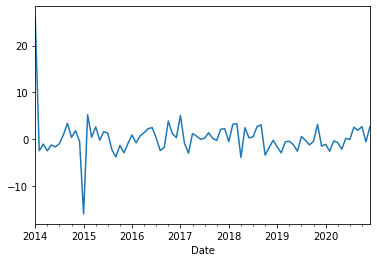

In [80]:
# print out the errors
results.resid.plot();

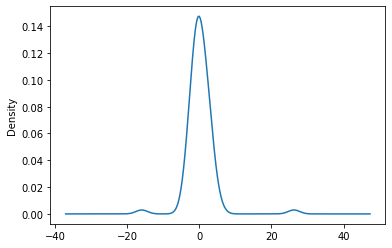

In [81]:
results.resid.plot.kde();

In [82]:
len(ttfm.index)

84

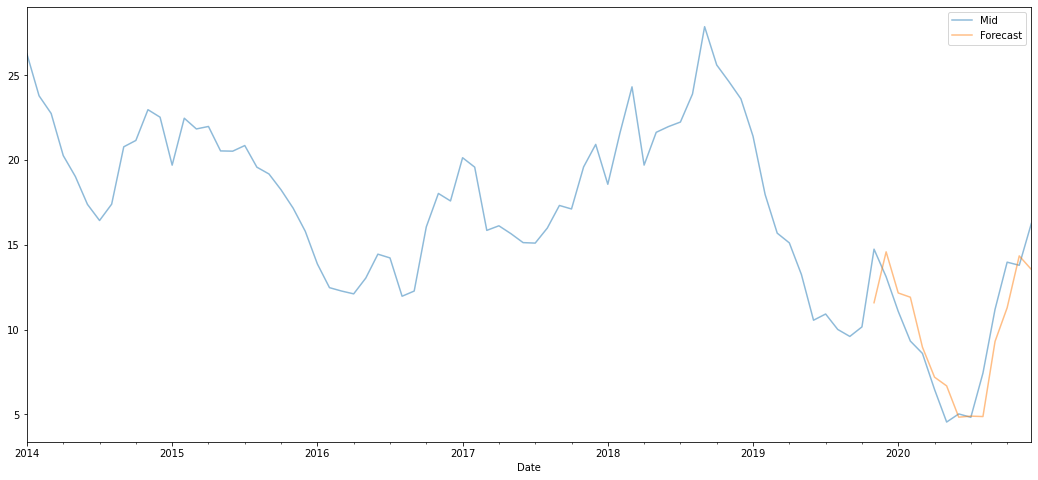

In [83]:
ttfm['Forecast'] = results.predict(start=70, end=84)
ttfm[['Mid', 'Forecast']].plot(figsize=(18,8), alpha=0.5);

To plot further out in time, we need to add more rows with datetime indices to the dataframe.

In [84]:
from pandas.tseries.offsets import DateOffset

In [85]:
futuredates = [ttfm.index[-1] + DateOffset(months=x) for x in range(1,25) ]

In [86]:
futuredates

[Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-05-01 00:00:00'),
 Timestamp('2021-06-01 00:00:00'),
 Timestamp('2021-07-01 00:00:00'),
 Timestamp('2021-08-01 00:00:00'),
 Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timestamp('2021-12-01 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-02-01 00:00:00'),
 Timestamp('2022-03-01 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-05-01 00:00:00'),
 Timestamp('2022-06-01 00:00:00'),
 Timestamp('2022-07-01 00:00:00'),
 Timestamp('2022-08-01 00:00:00'),
 Timestamp('2022-09-01 00:00:00'),
 Timestamp('2022-10-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00'),
 Timestamp('2022-12-01 00:00:00')]

In [87]:
future_df = pd.DataFrame(index=futuredates, columns=ttfm.columns)

In [88]:
final_df = pd.concat([ttfm, future_df], axis=0)
final_df

,Bid,Offer,Mid,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,Forecast
2014-01-01,26.231818,26.272727,26.252455,NaN,NaN,NaN,NaN,NaN
2014-02-01,23.767500,23.812500,23.790100,NaN,NaN,NaN,NaN,NaN
2014-03-01,22.716667,22.776190,22.746524,NaN,NaN,NaN,NaN,NaN
2014-04-01,20.232500,20.292500,20.262600,-0.4874,NaN,NaN,NaN,NaN
2014-05-01,18.993750,19.062500,19.028300,0.2033,0.6907,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
final_df['Forecast'] = results.predict(start=84, end=84+24)

In [90]:
final_df.tail()

,Bid,Offer,Mid,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,Forecast
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.429211
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.192720
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.904008
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.039608
2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.032624


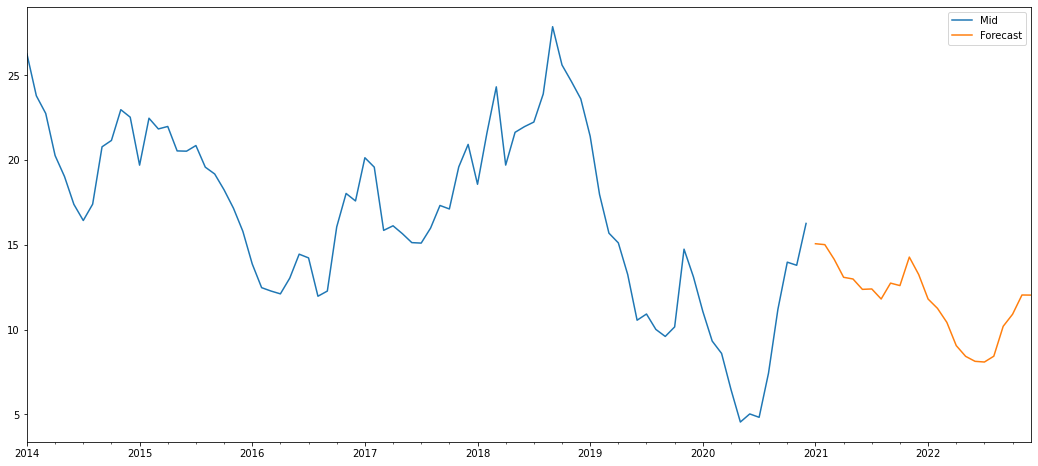

In [91]:
final_df[['Mid', 'Forecast']].plot(figsize=(18,8));

In [92]:
final_df['2020-10':'2021-06'][['Mid', 'Forecast']]

,Mid,Forecast
2020-10-01,13.975273,NaN
2020-11-01,13.792524,NaN
2020-12-01,16.260333,NaN
2021-01-01,NaN,15.062963
2021-02-01,NaN,15.009420
2021-03-01,NaN,14.140538
2021-04-01,NaN,13.083341
2021-05-01,NaN,12.983321
2021-06-01,NaN,12.371655
